In [1]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np

# read h5ad rna/seqfish data
device = torch.device('cuda:2')
adata_rna = sc.read_h5ad('/data/msyuan/Cross-omics-Annotator/SPANN_Package/sample_data/adata_rna.h5ad')
adata_seqfish = sc.read_h5ad('/data/msyuan/Cross-omics-Annotator/SPANN_Package/sample_data/adata_seqfish_40.h5ad')
# the original data has cell type information
adata_seqfish.obs = adata_seqfish.obs.drop('cell_type', axis=1)

In [2]:
# preprocess to get torch datasets and dataloaders
from preprocess import *

adata_cm, adata_spa, adata_rna = anndata_preprocess(adata_seqfish, adata_rna, spatial_labels=False)
source_sp_ds,target_sp_ds,source_cm_dl,target_cm_dl,test_source_cm_dl,test_target_cm_dl = generate_dataloaders(adata_cm,adata_spa,adata_rna)

/data/msyuan/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/data/msyuan/Cross-omics-Annotator/SPANN_Package/preprocess.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_cm.obs["labels"][adata_cm.obs["domain_id"]=='1'] = -1


rna_labels: [ 0  1  2  3  4  5  6  7  8  9 10]


In [3]:
# contruct SPANN model
from model import *

enc,dec,x_dim,z_dim = generate_ae_params(adata_cm, adata_spa, adata_rna)
spann = SPANN_model(x_dim, z_dim, enc, dec, class_num=len(adata_rna.obs['cell_type'].unique()), device=device)

[easydl] tensorflow not available!


In [4]:
# train SPANN model without validation

source_sp_ds,target_sp_ds,source_cm_dl,target_cm_dl,\
test_source_cm_dl,test_target_cm_dl = generate_dataloaders(adata_cm,adata_spa,adata_rna,batch_size=256)
adata_source, adata_target, threshold_test = spann.train(source_cm_dl,target_cm_dl,source_sp_ds,target_sp_ds,adata_spa.obs[["X","Y"]],
                                                         test_source_cm_dl, test_target_cm_dl,np.array(adata_rna.obs['labels']),np.unique(adata_rna.obs['cell_type']),
                                                         lr=2e-4,resolution=0.5,lambda_spa=0.001,lambda_cd=0.001,lambda_nb=10,
                                                         maxiter=5000,miditer1=2000,miditer2=4000,miditer3=4000)

#Iter 100: Reconstruction loss: 2.243307, KL loss: 99.192215, CLS loss: 1.650479, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 200: Reconstruction loss: 2.166400, KL loss: 129.111908, CLS loss: 1.486549, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 300: Reconstruction loss: 2.134961, KL loss: 85.156876, CLS loss: 1.276017, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 400: Reconstruction loss: 2.098627, KL loss: 87.590103, CLS loss: 1.202821, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 500: Reconstruction loss: 2.072297, KL loss: 74.694458, CLS loss: 1.010152, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 600: Reconstruction loss: 2.039676, KL loss: 72.406609, CLS loss: 0.963126, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 700: Reconstruction loss: 2.001389, KL loss: 87.180473, CLS loss: 0.875432, Spatial loss: 0.0

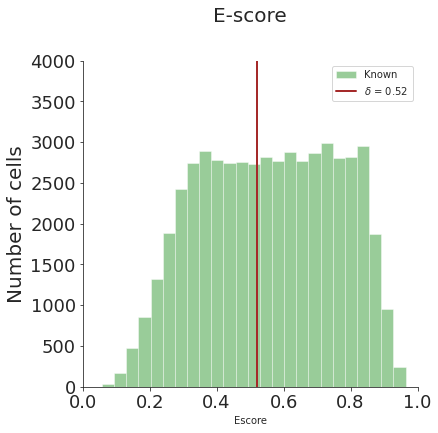

In [5]:
# distribution plot
from functions import *

dist_fig = distribution_plot(adata_target.obs['Escore'], threshold_test, bins=25, ylim=4000)

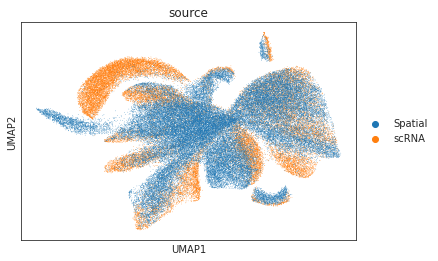

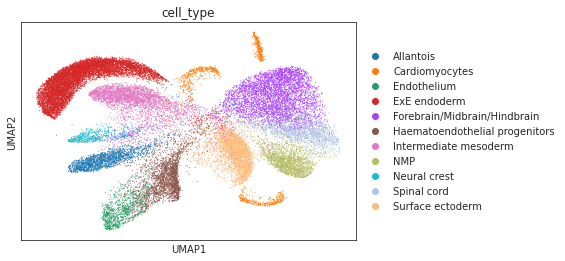

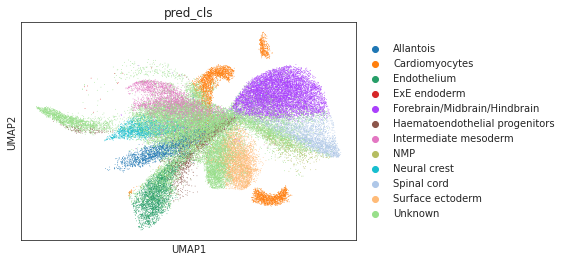

In [7]:
# umap visualizations
# umap plot colored by source and cell types

adata_total = sc.AnnData.concatenate(adata_source, adata_target)
sc.pp.neighbors(adata_total, use_rep="X")
sc.tl.umap(adata_total)
sc.pl.umap(adata_total, color="source", show=True)
sc.pl.umap(adata_total[adata_total.obs['source']=='scRNA'], color="cell_type", show=True)
sc.pl.umap(adata_total[adata_total.obs['source']=='Spatial'], color="pred_cls", show=True)

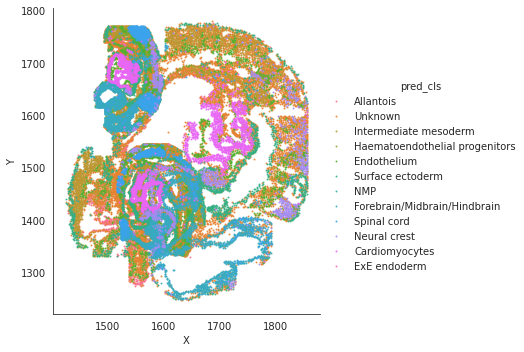

In [8]:
# spatial plot 
import seaborn as sns

sns.lmplot(data=adata_target.obs, x='X', y='Y',hue='pred_cls',fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})